<a href="https://colab.research.google.com/github/Imranzr/Developing_EEG_Based_Auditory_Brain_Computer_Interface_Using_Deep_Learning_-_Machine_Learning_Model/blob/main/Fine_Auditory_BCI_Dynamical_Window_Epoching_based_Machine_learning(ML)_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
pip install mne

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 47.9 MB/s eta 0:00:00


In [3]:
pip install pyriemann

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.6/115.6 kB 2.5 MB/s eta 0:00:00


In [4]:
import os
import argparse
import sys
import mne
import math
import time
import json
import numpy as np
from scipy.signal import butter, filtfilt
from pyriemann.estimation import XdawnCovariances
from pyriemann.tangentspace import TangentSpace
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, matthews_corrcoef

start = time.time()

def is_notebook():
    try:
        shell = get_ipython().__class__.__name__
        if shell == 'ZMQInteractiveShell':
            return True
        elif shell == 'TerminalInteractiveShell':
            return False
        else:
            return False
    except NameError:
        return False

if is_notebook():

    args = argparse.Namespace(s=None, c=None)
else:
    parser = argparse.ArgumentParser()
    parser.add_argument('-s', default=None)
    parser.add_argument('-c', default=None, type=int)
    args = parser.parse_args(args=[])

print(args.s)
print(args.c)
print(__doc__)

subject = 'sub-B'
if args.s is not None:
    subject = args.s
test_class =1
if args.c is not None:
    test_class = args.c

import numpy as np
fnum = np.array([[1,4],
                 [2,5],
                 [3,6]])

trig_id = [2,8,32]
tasks = ['low', 'low', 'mid', 'mid', 'high', 'high']
reject={'eeg':100e-6,'eog':500e-6}

import os
import json
repository_base = os.path.dirname(os.path.dirname(os.path.abspath('/content/drive/MyDrive/dataverse_files/results/sub-B_classification_scores.json')))

#repository_base = os.path.dirname(os.path.dirname(os.path.abspath('file_path')))
base = os.path.join(repository_base, "eeg")
save_base = os.path.join(repository_base, "results")
if not os.path.exists(save_base):
    os.makedirs(save_base)

Fs = 1000
fc = [1, 40]
resample = None

from scipy.signal import butter, filtfilt
def apply_filter(data, b, a):
    r = filtfilt(b=b, a=a, x=data)
    return r
b,a = butter(N = 2, Wn = np.array(fc)/(Fs/2), btype = 'bandpass', output = 'ba')

t_file = []
nt_file = []

target_file = []
non_target_file = []

for i in range(len(fnum.ravel())):
    fname = os.path.join(base, subject, "eeg", "%s_task-%s_run-%d_eeg.vhdr" % (subject, tasks[i], fnum.ravel()[i]))
    print(fname)
    if np.any(fnum[test_class-1] == fnum.ravel()[i]):
        if isinstance(target_file, list):
            target_file = mne.io.read_raw_brainvision(fname, preload=True, eog=('hEOG', 'vEOG'))
            target_file = target_file.apply_function(apply_filter, channel_wise=True, b=b, a=a)
            t_file.append(fnum.ravel()[i])
        else:
            tmp = mne.io.read_raw_brainvision(fname, preload=True, eog=('hEOG', 'vEOG'))
            tmp = tmp.apply_function(apply_filter, channel_wise=True, b=b, a=a)
            target_file = mne.concatenate_raws([target_file, tmp])
            t_file.append(fnum.ravel()[i])
    else:
        if isinstance(non_target_file, list):
            non_target_file = mne.io.read_raw_brainvision(fname, preload=True, eog=('hEOG', 'vEOG'))
            non_target_file = non_target_file.apply_function(apply_filter, channel_wise=True, b=b, a=a)
            nt_file.append(fnum.ravel()[i])
        else:
            tmp = mne.io.read_raw_brainvision(fname, preload=True, eog=('hEOG', 'vEOG'))
            tmp = tmp.apply_function(apply_filter, channel_wise=True, b=b, a=a)
            non_target_file = mne.concatenate_raws([non_target_file, tmp])
            nt_file.append(fnum.ravel()[i])
if resample is not None:
    target_file.resample(resample)
    non_target_file.resample(resample)

if resample != None:
    target_file.resample(resample)
    non_target_file.resample(resample)

target_eve = mne.events_from_annotations(target_file)
non_target_eve = mne.events_from_annotations(non_target_file)

event_id={'target_stimulus_id':-100,'non_target_stimulus_id':-500}

target_eve = mne.merge_events(target_eve[0], [trig_id[test_class-1]], event_id['target_stimulus_id'], replace_events=True)
non_target_eve = mne.merge_events(non_target_eve[0], [trig_id[test_class-1]], event_id['non_target_stimulus_id'], replace_events=True)

tmin,tmax= -0.02, 1.4
baseline=(0.0,0.01)
epochs_target = mne.Epochs(target_file, events=target_eve, event_id=event_id['target_stimulus_id'],
                            tmin=tmin, tmax=tmax, baseline=baseline,
                           reject=reject, preload=True)

for idx, event in enumerate(epochs_target.events):
    if event[2] == -100:
        annot_time = event[0] / epochs_target.info['sfreq']
        epochs_target.annotations.append(
            onset=annot_time, duration=0.001, description="target_event -100"
        )


None
None
Automatically created module for IPython interactive environment
/content/drive/MyDrive/dataverse_files/eeg/sub-B/eeg/sub-B_task-low_run-1_eeg.vhdr
Extracting parameters from /content/drive/MyDrive/dataverse_files/eeg/sub-B/eeg/sub-B_task-low_run-1_eeg.vhdr...
Setting channel info structure...


<ipython-input-4-2d7a8e5e8932>:91: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  target_file = mne.io.read_raw_brainvision(fname, preload=True, eog=('hEOG', 'vEOG'))
<ipython-input-4-2d7a8e5e8932>:91: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (100.00 Hz) will be stored.
  target_file = mne.io.read_raw_brainvision(fname, preload=True, eog=('hEOG', 'vEOG'))


Reading 0 ... 317919  =      0.000 ...   317.919 secs...
/content/drive/MyDrive/dataverse_files/eeg/sub-B/eeg/sub-B_task-low_run-4_eeg.vhdr
Extracting parameters from /content/drive/MyDrive/dataverse_files/eeg/sub-B/eeg/sub-B_task-low_run-4_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 312879  =      0.000 ...   312.879 secs...


<ipython-input-4-2d7a8e5e8932>:95: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  tmp = mne.io.read_raw_brainvision(fname, preload=True, eog=('hEOG', 'vEOG'))
<ipython-input-4-2d7a8e5e8932>:95: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (100.00 Hz) will be stored.
  tmp = mne.io.read_raw_brainvision(fname, preload=True, eog=('hEOG', 'vEOG'))


/content/drive/MyDrive/dataverse_files/eeg/sub-B/eeg/sub-B_task-mid_run-2_eeg.vhdr
Extracting parameters from /content/drive/MyDrive/dataverse_files/eeg/sub-B/eeg/sub-B_task-mid_run-2_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 314879  =      0.000 ...   314.879 secs...


<ipython-input-4-2d7a8e5e8932>:101: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  non_target_file = mne.io.read_raw_brainvision(fname, preload=True, eog=('hEOG', 'vEOG'))
<ipython-input-4-2d7a8e5e8932>:101: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (100.00 Hz) will be stored.
  non_target_file = mne.io.read_raw_brainvision(fname, preload=True, eog=('hEOG', 'vEOG'))


/content/drive/MyDrive/dataverse_files/eeg/sub-B/eeg/sub-B_task-mid_run-5_eeg.vhdr
Extracting parameters from /content/drive/MyDrive/dataverse_files/eeg/sub-B/eeg/sub-B_task-mid_run-5_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 315879  =      0.000 ...   315.879 secs...


<ipython-input-4-2d7a8e5e8932>:105: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  tmp = mne.io.read_raw_brainvision(fname, preload=True, eog=('hEOG', 'vEOG'))
<ipython-input-4-2d7a8e5e8932>:105: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (100.00 Hz) will be stored.
  tmp = mne.io.read_raw_brainvision(fname, preload=True, eog=('hEOG', 'vEOG'))


/content/drive/MyDrive/dataverse_files/eeg/sub-B/eeg/sub-B_task-high_run-3_eeg.vhdr
Extracting parameters from /content/drive/MyDrive/dataverse_files/eeg/sub-B/eeg/sub-B_task-high_run-3_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 319199  =      0.000 ...   319.199 secs...


<ipython-input-4-2d7a8e5e8932>:105: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  tmp = mne.io.read_raw_brainvision(fname, preload=True, eog=('hEOG', 'vEOG'))
<ipython-input-4-2d7a8e5e8932>:105: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (100.00 Hz) will be stored.
  tmp = mne.io.read_raw_brainvision(fname, preload=True, eog=('hEOG', 'vEOG'))


/content/drive/MyDrive/dataverse_files/eeg/sub-B/eeg/sub-B_task-high_run-6_eeg.vhdr
Extracting parameters from /content/drive/MyDrive/dataverse_files/eeg/sub-B/eeg/sub-B_task-high_run-6_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 321519  =      0.000 ...   321.519 secs...


<ipython-input-4-2d7a8e5e8932>:105: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  tmp = mne.io.read_raw_brainvision(fname, preload=True, eog=('hEOG', 'vEOG'))
<ipython-input-4-2d7a8e5e8932>:105: RuntimeWarning: Channels contain different lowpass filters. Highest (weakest) filter setting (100.00 Hz) will be stored.
  tmp = mne.io.read_raw_brainvision(fname, preload=True, eog=('hEOG', 'vEOG'))


Used Annotations descriptions: ['New Segment/', 'Stimulus/S  1', 'Stimulus/S  2', 'Stimulus/S  4', 'Stimulus/S  8', 'Stimulus/S 16', 'Stimulus/S 32', 'Stimulus/S129', 'Stimulus/S132', 'Stimulus/S144']
Used Annotations descriptions: ['New Segment/', 'Stimulus/S  1', 'Stimulus/S  2', 'Stimulus/S  4', 'Stimulus/S  8', 'Stimulus/S 16', 'Stimulus/S 32', 'Stimulus/S129', 'Stimulus/S132', 'Stimulus/S144']
Not setting metadata
119 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 119 events and 1421 original time points ...
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7', 'AF8']
    Rejecting  epo

# Dynamical_Window_Epoching

In [5]:
latencies_p300 = []
target_epochs_dynamic = []
non_target_epochs_dynamic = []
for epoch_idx, epoch in enumerate(epochs_target):
    picks = mne.pick_types(epochs_target.info, eeg=True, exclude='bads')
    data = epoch[picks].mean(axis=0)
    times = epochs_target.times
    p300_time_window = (0.3, 1.4)
    idx_start = np.searchsorted(times, p300_time_window[0])
    idx_end = np.searchsorted(times, p300_time_window[1])
    if idx_end > idx_start:
        data_window = data[idx_start:idx_end]
        peak_idx = np.argmax(data_window)
        peak_time = times[idx_start + peak_idx]
        latency_p300 = peak_time
    else:
        latency_p300 = None
    latencies_p300.append(latency_p300)
    if latency_p300 is not None:
        print(f"Epoch {epoch_idx + 1}: P300 latency = {latency_p300:.3f} seconds")
    else:
        print(f"Epoch {epoch_idx + 1}: P300 latency not found")
    if latency_p300 is not None:
        tmin_dynamic = max(-0.38, latency_p300 - 0.33)
        tmax_dynamic = latency_p300 + 0.33
        baseline_start = max(tmin_dynamic, baseline[0])
        baseline_end = min(tmax_dynamic, baseline[1])
        if baseline_start >= baseline_end:
            print(f"Adjusting baseline to fit within the epoch window: [{tmin_dynamic}, {tmax_dynamic}] s")
            baseline_start = tmin_dynamic
            baseline_end = tmin_dynamic + 0.045
        target_epoch_dynamic = mne.Epochs(target_file, events=target_eve, event_id=event_id['target_stimulus_id'],
                                          tmin=tmin_dynamic, tmax=tmax_dynamic,
                                          baseline=(baseline_start, baseline_end),
                                          reject=reject, preload=True)
        non_target_epoch_dynamic = mne.Epochs(non_target_file, events=non_target_eve, event_id=event_id['non_target_stimulus_id'],
                                              tmin=tmin_dynamic, tmax=tmax_dynamic,
                                              baseline=(baseline_start, baseline_end),
                                              reject=reject, preload=True)
        target_epochs_dynamic.append(target_epoch_dynamic)
        non_target_epochs_dynamic.append(non_target_epoch_dynamic)
    else:
        print("P300 latency not found, using default epoch window of -0.1 to 0.5 sec")
        target_epoch_default = mne.Epochs(target, events=target_eve, event_id=event_id['target_stimulus_id'],
                                          tmin=tmin, tmax=tmax, baseline=baseline,
                                          reject=reject, preload=True)
        non_target_epoch_default = mne.Epochs(non_target_file, events=non_target_eve, event_id=event_id['non_target_stimulus_id'],
                                              tmin=tmin, tmax=tmax, baseline=baseline,
                                              reject=reject, preload=True)
        target_epochs_dynamic.append(target_epoch_default)
        non_target_epochs_dynamic.append(non_target_epoch_default)

print("P300 latencies (in seconds) for all epochs:", latencies_p300)


Streaming output truncated to the last 5000 lines.
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7', 'AF3', 'AFz', 'AF4', 'AF8', 'F6', 'F8']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7', 'AF3', 'AFz', 'AF4', 'AF8', 'F5', 'F6', 'F8']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7', 'AF4', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7', 'AF3', 'AFz', 'AF4', 'AF8', 'F6', 'F8']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7', 'AF3', 'AFz', 'AF4', 'AF8', 'F6']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7', 'AF4', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7', 'AF4', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7', 'AF3', 'AFz', 'AF4', 'AF8', 'F6', 'F8']
    Rejecting  epoch based on EEG : ['Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7', 'AF4', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7', 'AF4', 'AF8

In [7]:
all_epochs = mne.concatenate_epochs([target_epoch_dynamic, non_target_epoch_dynamic])
epochs = all_epochs.copy().pick_types(eeg=True, eog=False)

Not setting metadata
251 matching events found
Applying baseline correction (mode: mean)


<ipython-input-7-017772bcdbcf>:1: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  all_epochs = mne.concatenate_epochs([target_epoch_dynamic, non_target_epoch_dynamic])


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


# Logistic Regression

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was depre

Classification Report:
{'non-target': {'precision': 0.8307692307692308, 'recall': 0.9364161849710982, 'f1-score': 0.8804347826086957, 'support': 173.0}, 'target': {'precision': 0.8035714285714286, 'recall': 0.5769230769230769, 'f1-score': 0.6716417910447762, 'support': 78.0}, 'accuracy': 0.8247011952191236, 'macro avg': {'precision': 0.8171703296703297, 'recall': 0.7566696309470875, 'f1-score': 0.7760382868267359, 'support': 251.0}, 'weighted avg': {'precision': 0.8223173241101528, 'recall': 0.8247011952191236, 'f1-score': 0.8155509047521788, 'support': 251.0}}


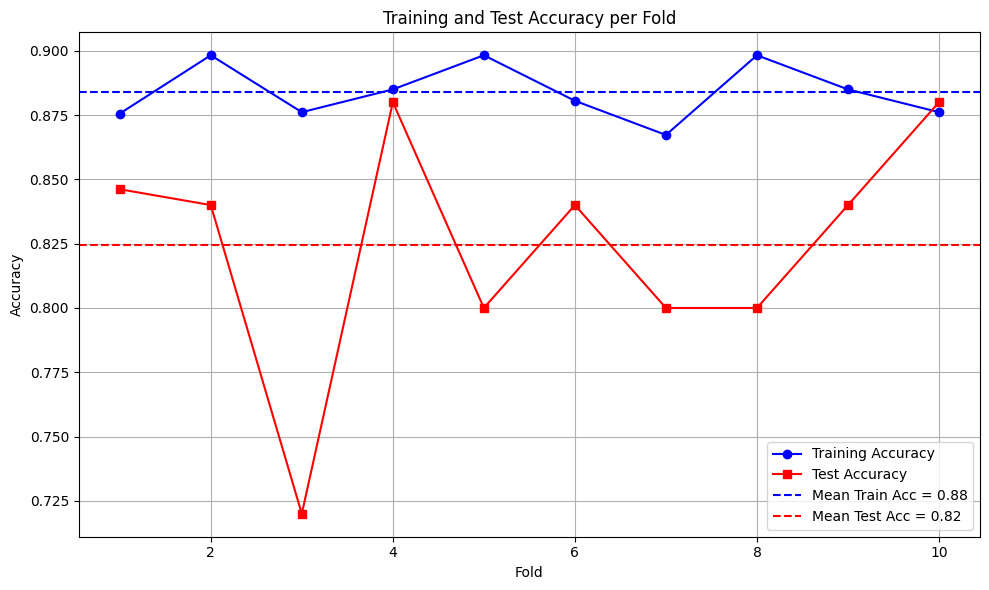

<Figure size 800x600 with 0 Axes>

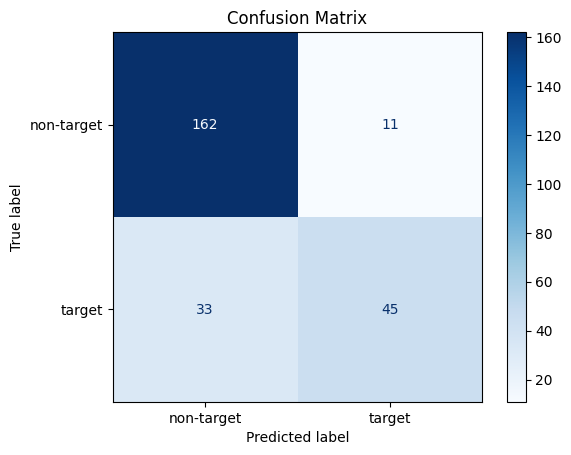

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from pyriemann.estimation import XdawnCovariances
from pyriemann.tangentspace import TangentSpace
import numpy as np

# Define the classifier pipeline without StandardScaler (XdawnCovariances handles 3D data)
clf = Pipeline([
    ('xdawn', XdawnCovariances(1)),  # Increase components to capture more signal
    ('tspace', TangentSpace(metric='riemann')),
    ('logreg', LogisticRegression(penalty='l2', solver='newton-cholesky', C=0.3, multi_class='ovr', max_iter=100))
])


#solver{‘lbfgs’, ‘liblinear’, ‘newton-cg’, ‘newton-cholesky’, ‘sag’, ‘saga’}, default=’lbfgs’

epochs_data = epochs.get_data()  # Shape: (n_samples, n_channels, n_timepoints)
labels = epochs.events[:, -1]
preds = np.zeros(len(labels))

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

train_accuracies, test_accuracies = [], []

for train_idx, test_idx in cv.split(epochs_data, labels):
    # Extract train and test data
    train_data = epochs_data[train_idx]
    test_data = epochs_data[test_idx]

    # Fit the classifier
    clf.fit(train_data, labels[train_idx])

    # Predict on train and test sets
    train_preds = clf.predict(train_data)
    test_preds = clf.predict(test_data)

    # Calculate train and test accuracies
    train_accuracy = accuracy_score(labels[train_idx], train_preds)
    test_accuracy = accuracy_score(labels[test_idx], test_preds)

    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

    # Save predictions for final evaluation
    preds[test_idx] = test_preds

# Print classification report
report = classification_report(labels, preds, target_names=['non-target', 'target'], output_dict=True)
print("Classification Report:")
print(report)

# Plot Train/Test Accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Training Accuracy', marker='o', color='blue')
plt.plot(range(1, len(test_accuracies) + 1), test_accuracies, label='Test Accuracy', marker='s', color='red')
plt.axhline(np.mean(train_accuracies), linestyle='--', color='blue', label=f"Mean Train Acc = {np.mean(train_accuracies):.2f}")
plt.axhline(np.mean(test_accuracies), linestyle='--', color='red', label=f"Mean Test Acc = {np.mean(test_accuracies):.2f}")
plt.title("Training and Test Accuracy per Fold")
plt.xlabel("Fold")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Confusion Matrix
cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['non-target', 'target'])
plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()


# Support Vector Machine (SVM)

{'non-target': {'precision': 0.8393782383419689, 'recall': 0.9364161849710982, 'f1-score': 0.8852459016393442, 'support': 173.0}, 'target': {'precision': 0.8103448275862069, 'recall': 0.6025641025641025, 'f1-score': 0.6911764705882353, 'support': 78.0}, 'accuracy': 0.8326693227091634, 'macro avg': {'precision': 0.8248615329640878, 'recall': 0.7694901437676004, 'f1-score': 0.7882111861137897, 'support': 251.0}, 'weighted avg': {'precision': 0.8303559035254372, 'recall': 0.8326693227091634, 'f1-score': 0.8249374728664897, 'support': 251.0}}
Classification Report:
{'non-target': {'precision': 0.8922155688622755, 'recall': 0.861271676300578, 'f1-score': 0.8764705882352941, 'support': 173.0}, 'target': {'precision': 0.7142857142857143, 'recall': 0.7692307692307693, 'f1-score': 0.7407407407407407, 'support': 78.0}, 'accuracy': 0.8326693227091634, 'macro avg': {'precision': 0.8032506415739948, 'recall': 0.8152512227656736, 'f1-score': 0.8086056644880174, 'support': 251.0}, 'weighted avg': {'p

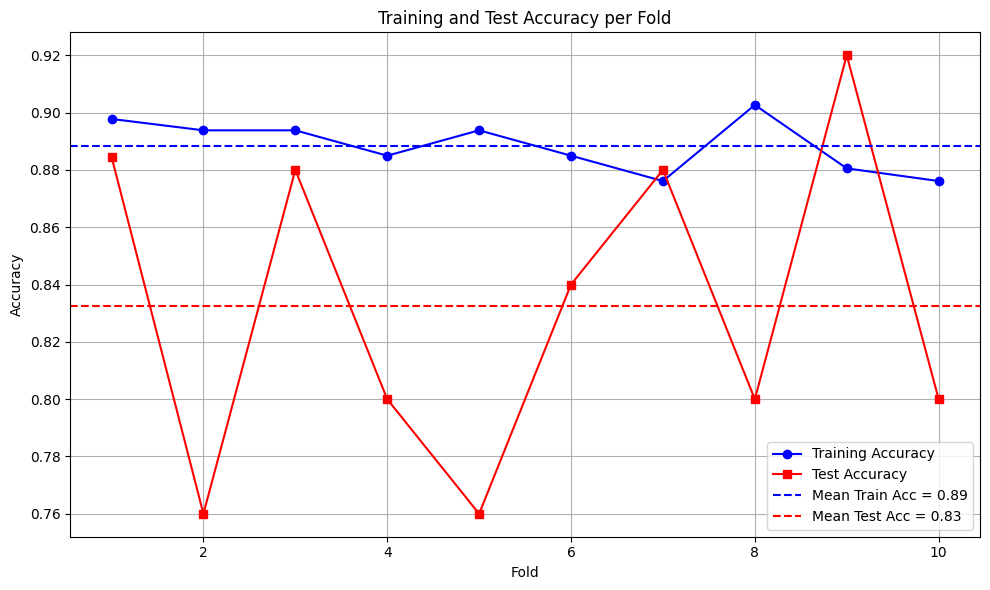

<Figure size 800x600 with 0 Axes>

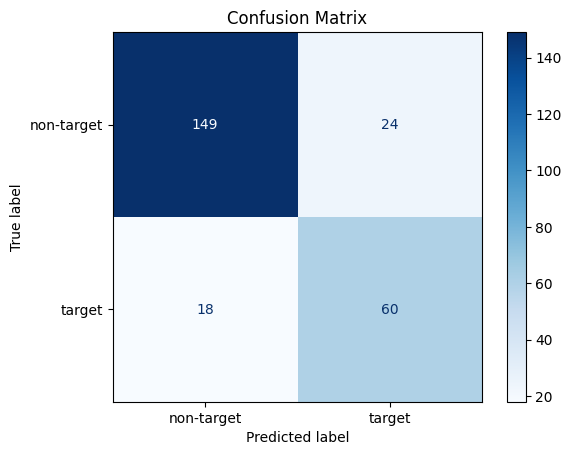

In [11]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

clf = make_pipeline(XdawnCovariances(8),
                    TangentSpace(metric='riemann'),
                    SVC(kernel='linear', C=1, decision_function_shape='ovr'))


epochs_data = epochs.get_data()
labels = epochs.events[:, -1]
preds = np.zeros(len(labels))

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

train_accuracies = []
test_accuracies = []
train_losses = []
test_losses = []
preds = np.empty(len(labels))
for train_idx, test_idx in cv.split(epochs_data, labels):
    clf.fit(epochs_data[train_idx], labels[train_idx])
    train_preds = clf.predict(epochs_data[train_idx])
    test_preds = clf.predict(epochs_data[test_idx])
    train_accuracy = accuracy_score(labels[train_idx], train_preds)
    test_accuracy = accuracy_score(labels[test_idx], test_preds)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    train_loss = np.mean(train_preds != labels[train_idx])
    test_loss = np.mean(test_preds != labels[test_idx])
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    preds[test_idx] = test_preds
report = classification_report(labels, preds, target_names=['non-target', 'target'], output_dict=True)
print(report)





import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import make_pipeline
from pyriemann.estimation import XdawnCovariances
from pyriemann.tangentspace import TangentSpace
from sklearn.svm import SVC

# Initialize the model pipeline
clf = make_pipeline(XdawnCovariances(1),
                    TangentSpace(metric='logeuclid'),
                    SVC(kernel='linear', C=1, decision_function_shape='ovr'))

# Extract data and labels
epochs_data = epochs.get_data()
labels = epochs.events[:, -1]

# Initialize variables
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
train_accuracies = []
test_accuracies = []
train_losses = []
test_losses = []
preds = np.empty(len(labels))

# Cross-validation loop
for train_idx, test_idx in cv.split(epochs_data, labels):
    clf.fit(epochs_data[train_idx], labels[train_idx])
    train_preds = clf.predict(epochs_data[train_idx])
    test_preds = clf.predict(epochs_data[test_idx])

    # Calculate accuracy and loss
    train_accuracy = accuracy_score(labels[train_idx], train_preds)
    test_accuracy = accuracy_score(labels[test_idx], test_preds)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

    train_loss = np.mean(train_preds != labels[train_idx])
    test_loss = np.mean(test_preds != labels[test_idx])
    train_losses.append(train_loss)
    test_losses.append(test_loss)

    preds[test_idx] = test_preds

# Generate classification report
report = classification_report(labels, preds, target_names=['non-target', 'target'], output_dict=True)
print("Classification Report:")
print(report)

# Overall numerical accuracy
print(f"Overall Train Accuracy: {np.mean(train_accuracies):.2f}")
print(f"Overall Test Accuracy: {np.mean(test_accuracies):.2f}")

# Plot training and test accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Training Accuracy', marker='o', color='blue')
plt.plot(range(1, len(test_accuracies) + 1), test_accuracies, label='Test Accuracy', marker='s', color='red')
plt.axhline(np.mean(train_accuracies), linestyle='--', color='blue', label=f"Mean Train Acc = {np.mean(train_accuracies):.2f}")
plt.axhline(np.mean(test_accuracies), linestyle='--', color='red', label=f"Mean Test Acc = {np.mean(test_accuracies):.2f}")
plt.title("Training and Test Accuracy per Fold")
plt.xlabel("Fold")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Confusion Matrix
cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['non-target', 'target'])
plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()


# Random Forest

{'non-target': {'precision': 0.9032258064516129, 'recall': 0.8092485549132948, 'f1-score': 0.8536585365853658, 'support': 173.0}, 'target': {'precision': 0.65625, 'recall': 0.8076923076923077, 'f1-score': 0.7241379310344828, 'support': 78.0}, 'accuracy': 0.8087649402390438, 'macro avg': {'precision': 0.7797379032258065, 'recall': 0.8084704313028013, 'f1-score': 0.7888982338099243, 'support': 251.0}, 'weighted avg': {'precision': 0.8264763526539005, 'recall': 0.8087649402390438, 'f1-score': 0.8134091053783186, 'support': 251.0}}


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1180: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


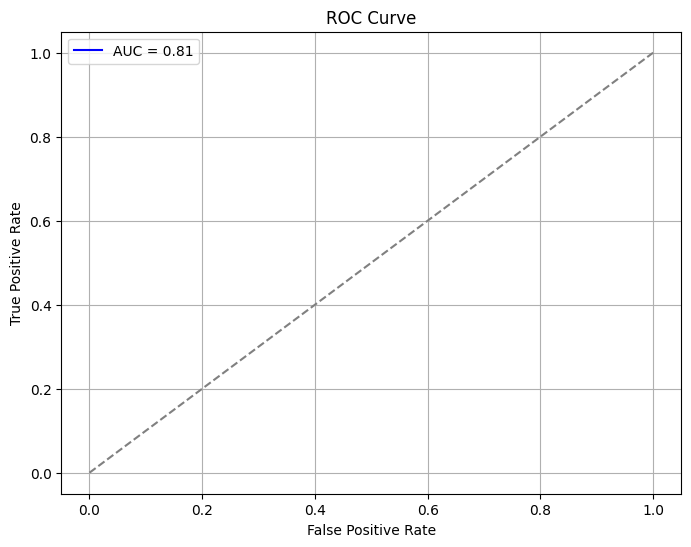

Logarithmic Loss: 11.20


<Figure size 800x600 with 0 Axes>

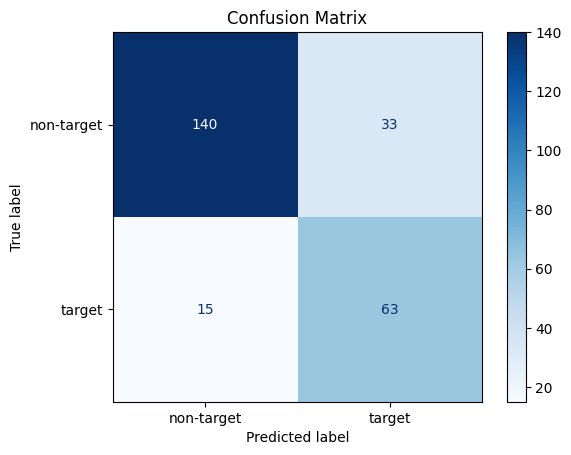

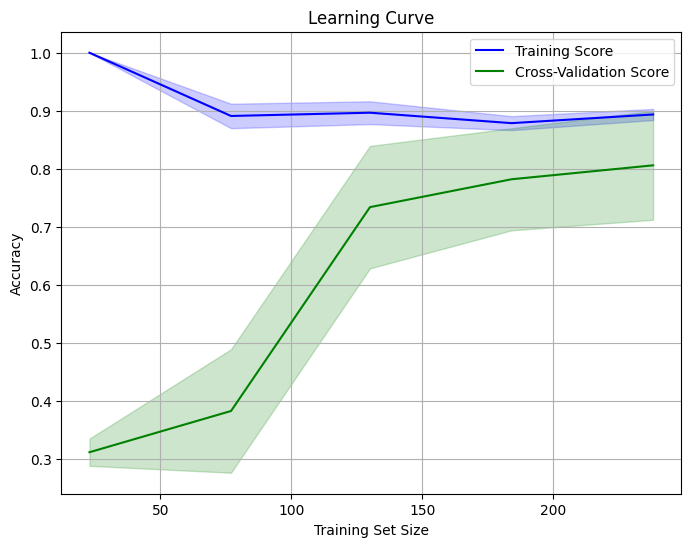

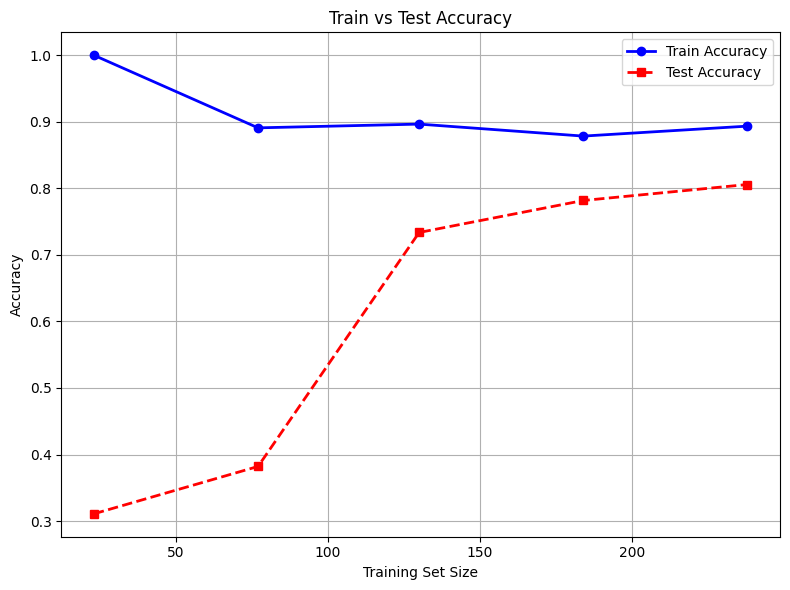

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import StratifiedKFold
from pyriemann.estimation import XdawnCovariances
from pyriemann.tangentspace import TangentSpace
import numpy as np




clf = make_pipeline(
    XdawnCovariances(1),
    TangentSpace(metric='riemann'),
    RandomForestClassifier(
        n_estimators=175,
        max_depth=30,
        max_features='sqrt',
        min_samples_split=8,
        class_weight='balanced_subsample',
        min_samples_leaf=30,
        bootstrap=False,  # Corrected: Use boolean True (not a string)
        random_state=42
    )
)



epochs_data = epochs.get_data()
labels = epochs.events[:, -1]

cv = StratifiedKFold(n_splits=20, shuffle=True, random_state=42)

train_accuracies, test_accuracies = [], []
train_losses, test_losses = [], []

preds = np.empty(len(labels))
for train_idx, test_idx in cv.split(epochs_data, labels):
    clf.fit(epochs_data[train_idx], labels[train_idx])
    train_preds = clf.predict(epochs_data[train_idx])
    test_preds = clf.predict(epochs_data[test_idx])
    train_accuracy = accuracy_score(labels[train_idx], train_preds)
    test_accuracy = accuracy_score(labels[test_idx], test_preds)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    train_loss = np.mean(train_preds != labels[train_idx])
    test_loss = np.mean(test_preds != labels[test_idx])

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    preds[test_idx] = test_preds

report = classification_report(labels, preds, target_names=['non-target', 'target'], output_dict=True)
print(report)






import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (roc_auc_score, roc_curve, log_loss,
                             confusion_matrix, ConfusionMatrixDisplay, classification_report)
from sklearn.model_selection import learning_curve
import seaborn as sns

# AUC and ROC Curve
fpr, tpr, thresholds = roc_curve(labels, preds, pos_label=1)
auc_score = roc_auc_score(labels, preds)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f"AUC = {auc_score:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.show()

# Logarithmic Loss
log_loss_value = log_loss(labels, preds)
print(f"Logarithmic Loss: {log_loss_value:.2f}")

# Confusion Matrix
cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['non-target', 'target'])

plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()

# Learning Curves
def plot_learning_curve(estimator, X, y, cv, scoring='accuracy'):
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, scoring=scoring)
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(8, 6))
    plt.plot(train_sizes, train_mean, label='Training Score', color='blue')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.2)
    plt.plot(train_sizes, test_mean, label='Cross-Validation Score', color='green')
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='green', alpha=0.2)
    plt.title("Learning Curve")
    plt.xlabel("Training Set Size")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid()
    plt.show()

    # Plot Train and Test Accuracy graph separately
    plt.figure(figsize=(8, 6))
    plt.plot(train_sizes, train_mean, label='Train Accuracy', color='blue', marker='o', linestyle='-', linewidth=2)
    plt.plot(train_sizes, test_mean, label='Test Accuracy', color='red', marker='s', linestyle='--', linewidth=2)
    plt.title("Train vs Test Accuracy")
    plt.xlabel("Training Set Size")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_learning_curve(clf, epochs_data, labels, cv)


# Polynomial Logistic Regression

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was depre

{'non-target': {'precision': 0.88, 'recall': 0.8901734104046243, 'f1-score': 0.8850574712643678, 'support': 173.0}, 'target': {'precision': 0.75, 'recall': 0.7307692307692307, 'f1-score': 0.7402597402597403, 'support': 78.0}, 'accuracy': 0.8406374501992032, 'macro avg': {'precision': 0.815, 'recall': 0.8104713205869275, 'f1-score': 0.8126586057620541, 'support': 251.0}, 'weighted avg': {'precision': 0.839601593625498, 'recall': 0.8406374501992032, 'f1-score': 0.8400605668087465, 'support': 251.0}}


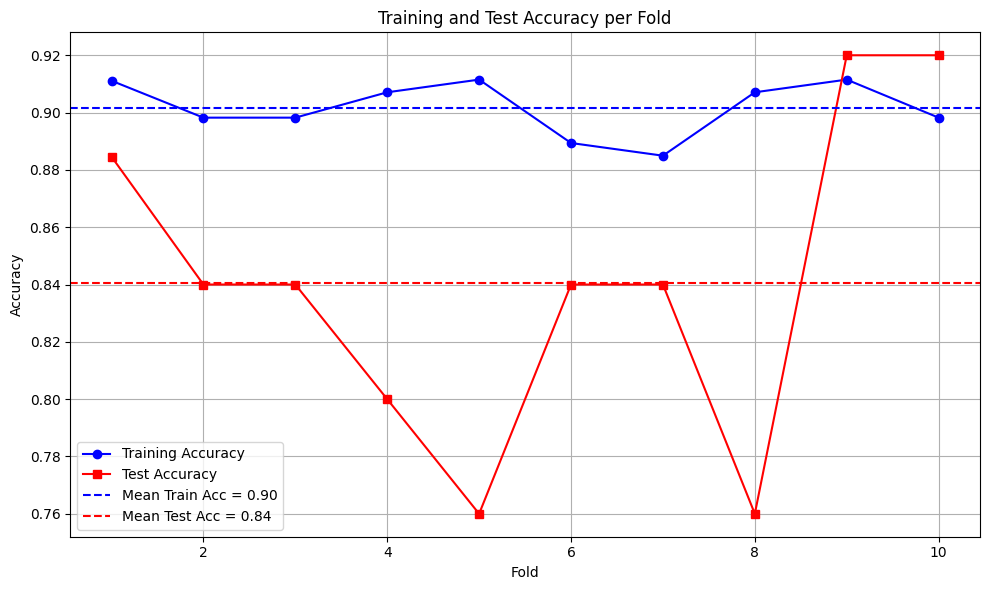

<Figure size 800x600 with 0 Axes>

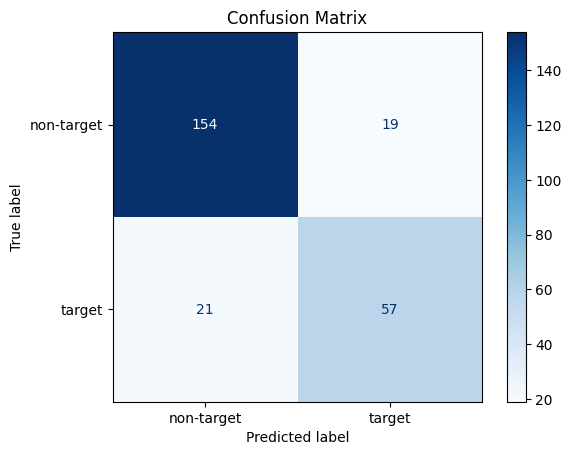

In [17]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression

clf = make_pipeline(XdawnCovariances(1),
                    TangentSpace(metric='riemann'),
                    PolynomialFeatures(degree=2, include_bias=False),
                    LogisticRegression(penalty='l2', solver='liblinear', C=1, multi_class='ovr'))

epochs_data = epochs.get_data()
labels = epochs.events[:, -1]
preds = np.zeros(len(labels))

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
train_accuracies = []
test_accuracies = []
train_losses = []
test_losses = []

preds = np.empty(len(labels))
for train_idx, test_idx in cv.split(epochs_data, labels):
    clf.fit(epochs_data[train_idx], labels[train_idx])
    train_preds = clf.predict(epochs_data[train_idx])
    test_preds = clf.predict(epochs_data[test_idx])
    train_accuracy = accuracy_score(labels[train_idx], train_preds)
    test_accuracy = accuracy_score(labels[test_idx], test_preds)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    train_loss = np.mean(train_preds != labels[train_idx])
    test_loss = np.mean(test_preds != labels[test_idx])
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    preds[test_idx] = test_preds


report = classification_report(labels, preds, target_names=['non-target', 'target'], output_dict=True)
print(report)





import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Plot Training and Test Accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Training Accuracy', marker='o', color='blue')
plt.plot(range(1, len(test_accuracies) + 1), test_accuracies, label='Test Accuracy', marker='s', color='red')
plt.axhline(np.mean(train_accuracies), linestyle='--', color='blue', label=f"Mean Train Acc = {np.mean(train_accuracies):.2f}")
plt.axhline(np.mean(test_accuracies), linestyle='--', color='red', label=f"Mean Test Acc = {np.mean(test_accuracies):.2f}")
plt.title("Training and Test Accuracy per Fold")
plt.xlabel("Fold")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Confusion Matrix
cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['non-target', 'target'])
plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()
